In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from bot.config.settings import Settings
from bot.core.encoder import TextEncoder
from bot.data.dataset import DatasetManager
from bot.model.utils import read_best_params
from sklearn.model_selection import (StratifiedKFold, cross_val_score, train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
encoder = TextEncoder(Settings.MODEL_CLS)
root = Path().cwd().parent # дефолтный путь не подходит
dm = DatasetManager(path=root / "data/data.csv")
X, y = encoder.encode(dm.get_X()), dm.get_y()
X_tain, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=Settings.RNG_INT, shuffle=True, stratify=y)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=Settings.RNG_INT)

In [3]:
X_tain.shape, X_test.shape

((502, 312), (56, 312))

In [4]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(label
 0    0.59761
 1    0.40239
 Name: proportion, dtype: float64,
 label
 0    0.589286
 1    0.410714
 Name: proportion, dtype: float64)

In [5]:
best_params = read_best_params(root / "bot/model/optunalogs/linear_svc_1743082245.json")
clf = LinearSVC(**best_params, max_iter=10_000, random_state=Settings.RNG_INT)

In [6]:
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')

print(f"f1: {f1_scores.mean()} +/- {f1_scores.std()}")
print(f"recall: {recall_scores.mean()} +/- {recall_scores.std()}")
print(f"precision: {precision_scores.mean()} +/- {precision_scores.std()}")

f1: 0.9554519211200019 +/- 0.024711599958682447
recall: 0.9596837944664032 +/- 0.04241605826180652
precision: 0.9539110671936758 +/- 0.043244669349447665


In [7]:
clf_calib = CalibratedClassifierCV(clf, method="sigmoid", cv=cv, ensemble=True, n_jobs=5)
clf_calib.fit(X_tain, y_train)

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                       ensemble=True,
                       estimator=LinearSVC(C=12.649715722402496, loss='hinge',
                                           max_iter=10000, random_state=42),
                       n_jobs=5)

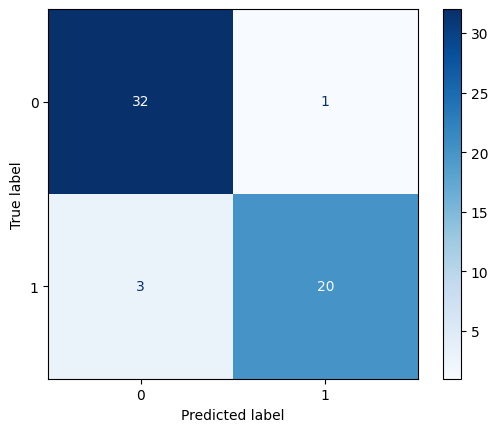

In [8]:
ConfusionMatrixDisplay.from_estimator(clf_calib, X_test, y_test, cmap='Blues')
plt.show()

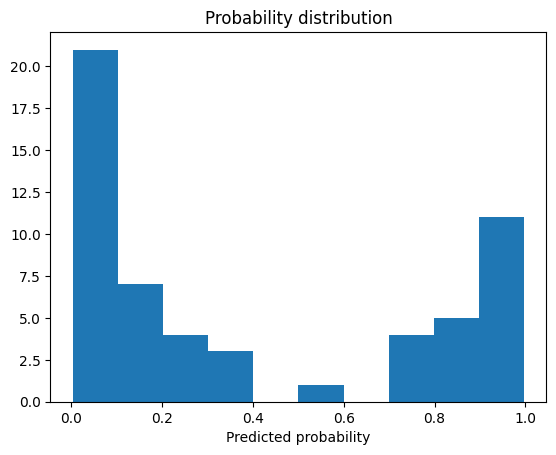

In [9]:
proba = clf_calib.predict_proba(X_test)[:, 1]
plt.hist(proba)
plt.xlabel("Predicted probability")
plt.title("Probability distribution")
plt.show()